In [1]:
import os
import sys
import glob
import scipy
import pickle
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')

from IPython.display import display, HTML

## Load parsed FastANI results (see previous notebook for details)

In [2]:
FFdb = pd.read_csv('/data1/bio_db/refseq/analysis/Manuscript/github_methods/bacterialEvolutionMetrics/DataTables/FastANI_comps.csv.gz')


## Make Figure (single plot)

In [7]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
from scipy.stats import kde

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

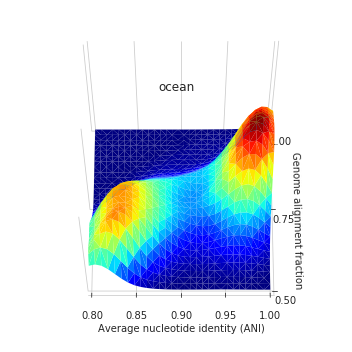

In [8]:
def _contour_plot(db, met1='fast_ani', met2='fastani_fracAligned', ax=False, MAX_COMPS=10000,
                 nbins=30, xlim=(0.8, 1), ylim=(0.5, 1), xlabel=False, ylabel=False, title=False):
    # Set up
    if ax == False:
        ax = plt.gca(projection='3d')
    
    # Subset if needed
    if len(db) > MAX_COMPS:
        Fdb = db.sample(MAX_COMPS)
    else:
        Fdb = db
    Fdb = Fdb[(Fdb[met1] >= xlim[0]) & (Fdb[met2] >= ylim[0])]
        
    x = Fdb[met1].append(pd.Series([xlim[0], xlim[1]]))
    y = Fdb[met2].append(pd.Series([ylim[0], ylim[1]]))
        
    # Calculate density
    xi, yi, zi = _calculate_density(x, y, nbins=nbins)
    
    # Plot density (3d)
    ax.plot_trisurf(xi.flatten(), yi.flatten(), zi, cmap=plt.cm.jet, linewidth=0, shade=True)
    
    # Rotate it
    #ax.view_init(55, 315) # good with flipped x/y
    ax.view_init(65, 270) # x = fastANI (0 -> 1), y= fastANI (0 -> 1)
    #ax.view_init(70, 270) # keep! This is what you did for v1 and v2
    #ax.view_init(45, 0) # x = fracAlinged (0 -> 1), y= fastANI (1 -> 0)
    
    # Adjust labels
    if ylabel == False:
        ax.set_ylabel(met2)
    else:
        ax.set_ylabel(ylabel)
        
    if xlabel == False:
        ax.set_xlabel(met1)
    else:
        ax.set_xlabel(xlabel)
    
    # Adjust limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Adjust ticks
    ax.set_xticks(list(np.arange(xlim[0], xlim[1], (xlim[1]-xlim[0])/4)) + [xlim[1]])
    ax.set_yticks(list(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/2)) + [ylim[1]])
    
    # Title
    #ax.set_title(title)
    ax.set_title(title, y=0.8)
    
    # Remove the grid https://stackoverflow.com/questions/11448972/changing-the-background-color-of-the-axes-planes-of-a-matplotlib-3d-plot
#     # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

#     # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Bonus: To get rid of the grid as well:
    ax.grid(True)
    
    plt.axvline(0.95, ls='--', color='red', linewidth=1)
    
    # Remove the z-axis
    #ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])


def _calculate_density(x, y, nbins=30):
    '''
    Calculate density.
    
    nbins is the number of points to calculate
    '''
    data = [x, y] 
    nbins = nbins
    k = kde.gaussian_kde(data)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    return xi, yi, zi
    
# fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'})
# curAx = ax[0,0]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fdb = FFdb[FFdb['fast_ani'] >= 0.8]
fdb = fdb[fdb['genome1'] != fdb['genome2']]


_contour_plot(fdb[(fdb['method'] == 'ocean')], met1='fast_ani', met2='fastani_fracAligned',
                  xlabel='Average nucleotide identity (ANI)', ylabel='Genome alignment fraction',
                  title='ocean', nbins=30, xlim=(0.8, 1), ylim=(0.5,1))#, ax=curAx)


plt.gcf().set_size_inches(5,5)
plt.show()

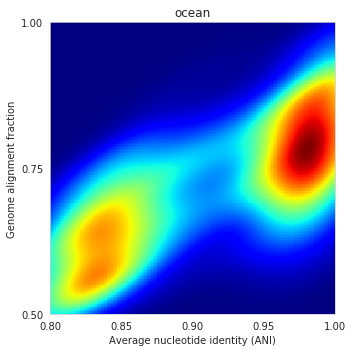

In [9]:
def _contour_plot(db, met1='fast_ani', met2='fastani_fracAligned', ax=False, MAX_COMPS=10000,
                 nbins=30, xlim=(0.8, 1), ylim=(0.5, 1), xlabel=False, ylabel=False, title=False):
    # Set up
    if ax == False:
        #ax = plt.gca(projection='3d')
        ax = plt.gca()
    
    # Subset if needed
    if len(db) > MAX_COMPS:
        Fdb = db.sample(MAX_COMPS)
    else:
        Fdb = db
    Fdb = Fdb[(Fdb[met1] >= xlim[0]) & (Fdb[met2] >= ylim[0])]
        
    x = Fdb[met1].append(pd.Series([xlim[0], xlim[1]]))
    y = Fdb[met2].append(pd.Series([ylim[0], ylim[1]]))
        
    # Calculate density
    
    xi, yi, zi = _calculate_density(x, y, nbins=nbins)
    
    # Plot density (3d)
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, linewidth=0)
    #ax.pcolormesh(xi.flatten(), yi.flatten(), zi, cmap=plt.cm.jet, linewidth=0, shade=True)
    
    # Rotate it
    #ax.view_init(55, 315) # good with flipped x/y
    #ax.view_init(90, 270) # x = fastANI (0 -> 1), y= fastANI (0 -> 1)
    #ax.view_init(70, 270) # keep! This is what you did for v1 and v2
    #ax.view_init(45, 0) # x = fracAlinged (0 -> 1), y= fastANI (1 -> 0)
    
    # Adjust labels
    if ylabel == False:
        ax.set_ylabel(met2)
    else:
        ax.set_ylabel(ylabel)
        
    if xlabel == False:
        ax.set_xlabel(met1)
    else:
        ax.set_xlabel(xlabel)
    
    # Adjust limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Adjust ticks
    ax.set_xticks(list(np.arange(xlim[0], xlim[1], (xlim[1]-xlim[0])/4)) + [xlim[1]])
    ax.set_yticks(list(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/2)) + [ylim[1]])
    
    # Title
    #ax.set_title(title)
    ax.set_title(title)#, y=0.8)
    
    # Remove the grid https://stackoverflow.com/questions/11448972/changing-the-background-color-of-the-axes-planes-of-a-matplotlib-3d-plot
#     # First remove fill
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False

#     # Now set color to white (or whatever is "invisible")
#     ax.xaxis.pane.set_edgecolor('w')
#     ax.yaxis.pane.set_edgecolor('w')
#     ax.zaxis.pane.set_edgecolor('w')

    # Bonus: To get rid of the grid as well:
    ax.grid(True)
    
    #plt.axvline(0.95, ls='--', color='red', linewidth=1)
    
    # Remove the z-axis
    #ax.w_zaxis.line.set_lw(0.)
    #ax.set_zticks([])


def _calculate_density(x, y, nbins=30):
    '''
    Calculate density.
    
    nbins is the number of points to calculate
    '''
    data = [x, y] 
    nbins = nbins
    k = kde.gaussian_kde(data)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    return xi, yi, zi
    
# fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'})
# curAx = ax[0,0]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fdb = FFdb[FFdb['fast_ani'] >= 0.8]
fdb = fdb[fdb['genome1'] != fdb['genome2']]


_contour_plot(fdb[(fdb['method'] == 'ocean')], met1='fast_ani', met2='fastani_fracAligned',
                  xlabel='Average nucleotide identity (ANI)', ylabel='Genome alignment fraction',
                  title='ocean', nbins=200, xlim=(0.8, 1), ylim=(0.5,1))#, ax=curAx)


plt.gcf().set_size_inches(5,5)
plt.show()

## Make Figure (all)

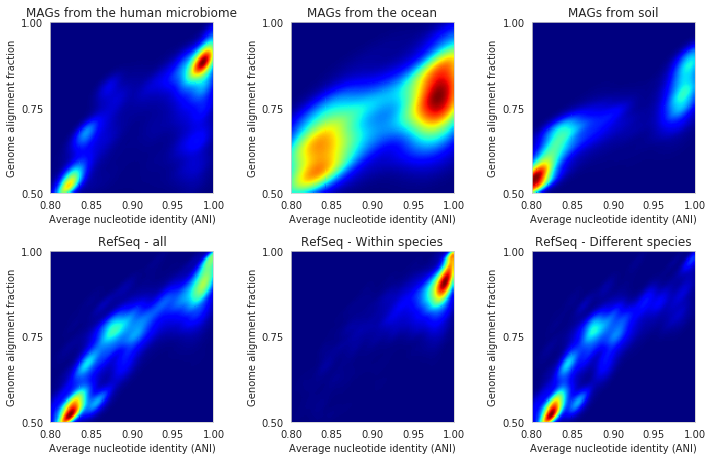

In [10]:
fdb = FFdb[FFdb['fast_ani'] >= 0.8]
fdb = fdb[fdb['genome1'] != fdb['genome2']]
    
fig, ax = plt.subplots(nrows=2, ncols=3)#, subplot_kw={'projection': '3d'})
fig.set_size_inches(10, 6.5)

i2s = {}
i2s['refseq'] = 'RefSeq'
i2s['infant'] = 'MAGs from the human microbiome'
i2s['ocean'] = 'MAGs from the ocean'
i2s['soil'] = 'MAGs from soil'

for i, m in enumerate(['infant', 'ocean', 'soil', 'refseq', 'refseq_s', 'refseq_g']):
    if m == 'refseq_s':
        db = fdb[fdb['method'] == 'refseq']
        db = db[db['same_species'] == True]
        d = 'RefSeq - Within species'
    elif m == 'refseq_g':
        db = fdb[fdb['method'] == 'refseq']
        db = db[(db['same_species'] == False)]
        d = 'RefSeq - Different species'
    else:
        db = fdb[fdb['method'] == m]
        d = i2s[m]
        
    if m == 'refseq':
        d = 'RefSeq - all'
    
    curAx = ax[int(i/3), i%3] 
    
    _contour_plot(db, met1='fast_ani', met2='fastani_fracAligned', MAX_COMPS=100000000,
                  xlabel='Average nucleotide identity (ANI)', ylabel='Genome alignment fraction',
                  title=d, nbins=150, ax=curAx)

    i += 1

    
plt.subplots_adjust(hspace=0.2)
#plt.gcf().savefig('/data1/bio_db/refseq/analysis/figures/SpeciesDeliniation_Figure1_v6.3.pdf', bbox_inches='tight')
plt.show()
